## Import libraries

In [1]:
import numpy as np
from numpy import sqrt, argmax
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

import syft as sy

# import opacus
# from opacus import PrivacyEngine

import warnings
from pprint import pprint
warnings.filterwarnings("ignore")

import pandas as pd
import re
from nltk.corpus import stopwords

# from syft.frameworks.torch.nn import GRU
from handcrafted_GRU import GRU
# from opacus.layers import DPGRU

from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device:{device}")

print(f"Torch Ver: {torch.__version__}")
# print(f"Opacus Ver: {opacus.__version__}")
# print(f"Syft Ver: {sy.__version__}")


Device:cuda
Torch Ver: 1.4.0


In [2]:
STOPWORDS = set(stopwords.words('indonesian'))
# print(f"STOPWORDS:\n {STOPWORDS}")

def clean_text(text):
    # print(f"\n\nOriginal Text: {text}")
    text = text.lower()
    # print(f"\nCase Lowered Text: {text}")
    text = re.sub(r'[^a-z\s]', '', text)
    # print(f"\nRegexed Text: {text}")
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    # print(f"\nStopwords Removed Text: {text}")
    return text

def tokenize(text, word_to_idx):
    tokens = []
    for word in text.split():
        if word in word_to_idx:
            tokens.append(word_to_idx[word])
        else:
            tokens.append(0)
    return tokens

def pad_and_truncate(messages, max_length=30):
    features = np.zeros((len(messages), max_length), dtype=int)
    # pprint(f"Messages: {messages}\nFeatures: {features}")
    for i, sms in enumerate(messages):
        # print(f"\ni: {i}\nSMS:{sms}")
        if len(sms):
            features[i, -len(sms):] = sms[:max_length]
    return features

In [3]:
if __name__ == '__main__':
    data = pd.read_csv('train_sms_1240.csv', sep=',', names=['Teks', 'Label'], encoding= 'unicode_escape')
    data = data.sample(frac = 1)
    # Lowercase, remove unnecessary char with regex, remove stop words
    data.Teks = data.Teks.apply(clean_text)
    # print(data.Teks)
    words = set((' '.join(data.Teks)).split())
    # print(words)
    word_to_idx = {word: i for i, word in enumerate(words, start=1)}
    # pprint(word_to_idx)
    tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
    # print(tokens)
    inputs = pad_and_truncate(tokens)
    # pprint(inputs)
    labels = np.array((data.Label == '1').astype(int))

    np.save('labels.npy', labels)
    np.save('inputs.npy', inputs)

## Training model with Federated learning

### Training and model hyperparameters

In [4]:
# Training params
TRAIN_VOCAB_SIZE = int(inputs.max()) + 1
EPOCHS = 100
CLIP = 5 # gradient clipping - to avoid gradient explosion (frequent in RNNs)
lr = 0.01
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Train and Test Split

In [5]:
original_inputs = np.load('inputs.npy')
original_labels = np.load('labels.npy')

inputs = torch.tensor(original_inputs)
labels = torch.tensor(original_labels)

# splitting training and test data
# 20% of the data will be for Tests.
pct_test = 0.2

#20% of total data
pct_test_count = -int(len(labels)*pct_test)

# Get 80% of Train LABELS from left.
train_labels = labels[:pct_test_count]
# print(f"Train Labels: [:{pct_test_count}]")

# Get 80% of Train INPUTS from left.
train_inputs = inputs[:pct_test_count]
# print(f"Train Inputs: [:{pct_test_count}]")

# Get the rest of the LABEL data for test on the right (20%) 
test_labels = labels[pct_test_count:]
# print(f"Test Labels: [{pct_test_count}:]")

# Get the rest of the INPUT data for test on the right (20%)
test_inputs = inputs[pct_test_count:]
# print(f"Test Inputs: [{pct_test_count}:]")


SAMPLE_SIZE = len(labels)
# print(f"Sample Size: {SAMPLE_SIZE}")

# print(f"20% of Sample Size: {SAMPLE_SIZE*pct_test}")

# For Local Model Evaluation
original_test_inputs = original_inputs[pct_test_count:]
original_test_labels = original_labels[pct_test_count:]

### VirtualWorkers

In [6]:
# Hook that extends the Pytorch library 
# to enable all computations with pointers of tensors sent to other workers
hook = sy.TorchHook(torch)

# Creating 2 virtual workers Syft v0.2.9
anne = sy.VirtualWorker(hook, id="anne")
bob = sy.VirtualWorker(hook, id="bob")

workers = [anne, bob]

# this is done to have the local worker (you on your notebook!) have a registry
# of objects like every other workers, which is disabled by default but needed here
# sy.local_worker.is_client_worker = False


# threshold indexes for dataset split (one half for Bob, other half for Anne)
train_idx = int(len(train_labels)/2)
test_idx = int(len(test_labels)/2)

# Sending toy datasets to virtual workers
bob_train_dataset = sy.BaseDataset(train_inputs[:train_idx], train_labels[:train_idx]).send(bob)
anne_train_dataset = sy.BaseDataset(train_inputs[train_idx:], train_labels[train_idx:]).send(anne)
bob_test_dataset = sy.BaseDataset(test_inputs[:test_idx], test_labels[:test_idx]).send(bob)
anne_test_dataset = sy.BaseDataset(test_inputs[test_idx:], test_labels[test_idx:]).send(anne)

# print(f"Train Index: {train_idx}")
# print(f"Test Index: {test_idx}")

# print(f"Anne's Data Amount: {len(train_inputs[train_idx:])}")
# print(f"Bob's Data Amount: {len(train_inputs[:train_idx])}")


# Creating federated datasets, an extension of Pytorch TensorDataset class 
# for TRAINING METHOD #1 (with aggregation)
bob_federated_train_dataset = sy.FederatedDataset([bob_train_dataset])
anne_federated_train_dataset = sy.FederatedDataset([anne_train_dataset])
bob_federated_test_dataset = sy.FederatedDataset([bob_test_dataset])
anne_federated_test_dataset = sy.FederatedDataset([anne_test_dataset])


merged_test_dataset = list(zip(original_test_inputs, original_test_labels))

# print(f"Input:{original_test_inputs[1]}\t Label:{original_test_labels[1]}")
# print(merged_test_dataset[0])

def collate_batch(batch):
        label_list, text_list = [], []
        for (_label, _text) in batch:
                label_list.append(_label)
                text_list.append(_text)
        return label_list, text_list

original_test_dataloader = DataLoader(merged_test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

### Import GRU Model

In [7]:
# Initiating the model
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# model = GRU(vocab_size=TRAIN_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
# torch.set_default_tensor_type('torch.FloatTensor')

def make_model():
    model = GRU(vocab_size=TRAIN_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
    return model
    
local_model = make_model()

models, train_dataloaders, test_dataloaders, optimizers, privacy_engines = [], [], [], [], []

### Attaching model, dataloaders, and optimizers to each worker

In [8]:
for worker in workers:
    model = make_model()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.send(worker)
    if(worker == anne):
        train_dataset = anne_federated_train_dataset
        test_dataset = anne_federated_test_dataset
    elif(worker == bob):
        train_dataset = bob_federated_train_dataset
        test_dataset = bob_federated_test_dataset


    train_dataloader = sy.FederatedDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = sy.FederatedDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    models.append(model)
    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)
    optimizers.append(optimizer)

### Functions to aggregate remote models and to send new updates

In [9]:
def federated_aggregation(local_model, models):
    with torch.no_grad():
        for local_param, *remote_params in zip(*([local_model.parameters()] + [model.parameters() for model in models])):
            param_stack = torch.zeros(*remote_params[0].shape)
            for remote_param in remote_params:
                param_stack += remote_param.copy().get()
                # print(f"Param Stack Sum: {param_stack}")
            param_stack /= len(remote_params)
            # print(f"Param Stack Division: {param_stack}")
            local_param.set_(param_stack)

def send_new_models(local_model, models):
    with torch.no_grad():
        for remote_model in models:
            for new_param, remote_param in zip(local_model.parameters(), remote_model.parameters()):
                worker = remote_param.location
                remote_value = new_param.send(worker)
                remote_param.set_(remote_value) 

### Training Method #1

In [10]:
train_losses = [[], []]
test_losses = []

def train(epoch):
    # 1. Send new version of the model
    send_new_models(local_model, models)

    # 2. Train remotely the models
    for i, worker in enumerate(workers):
        train_dataloader = train_dataloaders[i]
        model = models[i]
        optimizer = optimizers[i]
        
        model.train()
        criterion = nn.BCELoss() # for two class classification
        losses = []   
    
        for data, target in train_dataloader:            
            data = data.to(torch.long)
            h = torch.Tensor(torch.zeros(BATCH_SIZE, HIDDEN_DIM)).send(worker)  
            
            # Call zero grad to clear previous gradient before every training passses.
            optimizer.zero_grad()

            # print(f"Data:{data}\nTarget: {target}\n")

            # print(f"Worker: {worker}\nWorker Objects: {worker.object_store._objects}")

            output, _ = model(data.to(torch.long), h)
            # print(f"Output: {output}")
            loss = criterion(output.squeeze(), target.float())
            loss.backward()

            # # Clipping the gradient to avoid explosion
            # nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            losses.append(loss.get()) 
            optimizer.step()

        sy.local_worker.clear_objects()
        

        train_loss = sum(losses) / len(losses)
        train_losses[i].append(train_loss.item())

        print(
            f"[{worker.id}]\t"
            f"Train Epoch: {epoch} \t"
            f"Train Loss: {train_loss:.4f} ")

    # 3. Federated aggregation of the updated models
    federated_aggregation(local_model, models)


def eval(epoch, last_loss, trigger_times, patience):
    # 4. Evaluate the model
    local_model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in original_test_dataloader:
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))
            output, _ = local_model(torch.LongTensor(inputs), h)
            criterion = nn.BCELoss()
            labels = torch.LongTensor(labels)
            loss = criterion(output.squeeze(), labels.float())
            eval_losses.append(loss)
            preds = output.squeeze()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))
    
    score = roc_auc_score(test_labels_list, test_preds)

    eval_loss = sum(eval_losses) / len(eval_losses)
    test_losses.append(eval_loss.item())

            
    # Early Stopping
    if eval_loss > last_loss:
        trigger_times += 1
        print(f"Trigger Times: {trigger_times}")
        
        if trigger_times >= patience:
            print("EARLY STOPPING! STARTING TEST PROCESS...")

    else:
        print(f"Trigger Times: 0")
        trigger_times = 0
    
    last_loss = eval_loss

    print(
        f"Eval Epoch: {epoch} \t"
        f"AUC: {score:.3%} \t"
        f"Eval Loss: {eval_loss:.4f} \n\n")

    return last_loss, trigger_times



In [11]:
# For Early Stopping
last_loss = 100
patience = 3
trigger_times = 0

for epoch in range(EPOCHS):
    train(epoch)
    last_loss, trigger_times = eval(epoch, last_loss, trigger_times, patience)
    if trigger_times >= patience:
        print("EARLY STOPPING! STARTING TEST PROCESS...")
        break

[anne]	Train Epoch: 0 	Train Loss: 0.7541 
[bob]	Train Epoch: 0 	Train Loss: 0.7112 
Trigger Times: 0
Eval Epoch: 0 	AUC: 51.240% 	Eval Loss: 0.7199 


[anne]	Train Epoch: 1 	Train Loss: 0.7403 
[bob]	Train Epoch: 1 	Train Loss: 0.6968 
Trigger Times: 0
Eval Epoch: 1 	AUC: 51.529% 	Eval Loss: 0.7104 


[anne]	Train Epoch: 2 	Train Loss: 0.7294 
[bob]	Train Epoch: 2 	Train Loss: 0.6947 
Trigger Times: 0
Eval Epoch: 2 	AUC: 51.656% 	Eval Loss: 0.6995 


[anne]	Train Epoch: 3 	Train Loss: 0.7117 
[bob]	Train Epoch: 3 	Train Loss: 0.6827 
Trigger Times: 0
Eval Epoch: 3 	AUC: 51.953% 	Eval Loss: 0.6911 


[anne]	Train Epoch: 4 	Train Loss: 0.7060 
[bob]	Train Epoch: 4 	Train Loss: 0.6749 
Trigger Times: 0
Eval Epoch: 4 	AUC: 52.114% 	Eval Loss: 0.6812 


[anne]	Train Epoch: 5 	Train Loss: 0.7031 
[bob]	Train Epoch: 5 	Train Loss: 0.6678 
Trigger Times: 0
Eval Epoch: 5 	AUC: 52.284% 	Eval Loss: 0.6741 


[anne]	Train Epoch: 6 	Train Loss: 0.6943 
[bob]	Train Epoch: 6 	Train Loss: 0.6640 
Tri

### Plot Losses

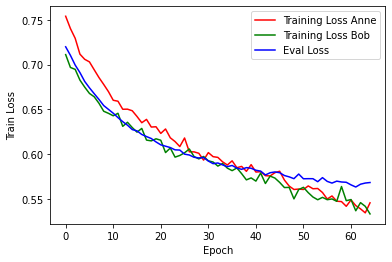

In [12]:
plt.plot(train_losses[0], 'r')
plt.plot(train_losses[1], 'g')
plt.plot(test_losses, 'b')
plt.legend(['Training Loss Anne', 'Training Loss Bob' , 'Eval Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Save First Model

In [13]:
# Save
PATH = "local_state_dict_model.pt"
torch.save(local_model.state_dict(), PATH)

### Prepare Test Data

In [256]:
data = pd.read_csv('test_sms_540.csv', sep=',', encoding= 'unicode_escape', names=['Teks', 'Label'])
# data = data.sample(frac = 1)
# Lowercase, remove unnecessary char with regex, remove stop words
data.Teks = data.Teks.apply(clean_text)
#     print(data.Teks)
words = set((' '.join(data.Teks)).split())
#     print(words)
word_to_idx = {word: i for i, word in enumerate(words, start=1)}
#     pprint(word_to_idx)
tokens = data.Teks.apply(lambda x: tokenize(x, word_to_idx))
#     print(tokens)
inputs = pad_and_truncate(tokens)
#     pprint(inputs)
labels = np.array((data.Label == '1').astype(int))

np.save('test_labels.npy', labels)
np.save('test_inputs.npy', inputs)

test_inputs = torch.tensor(np.load('test_inputs.npy'))
test_labels = torch.tensor(np.load('test_labels.npy'))


In [259]:
# Testing params
VOCAB_SIZE = int(test_inputs.max()) + 1
TEST_VOCAB_SIZE = TRAIN_VOCAB_SIZE 
lr = 0.01
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

### Load and Test First Model

Best Threshold=0.309255, G-Mean=0.529
Amount of test data: 540


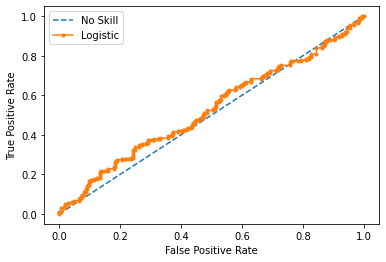

ROC Accuracy Score: 0.5280046587328844

Accuracy Score: 0.512962962962963

Confusion Matrix: 
[[163 184]
 [ 79 114]]

TP: 163	 FN: 184
FP: 79	 TN: 114

Precision: 0.6735537190082644
Recall:0.4697406340057637
F1 Score: 0.46435845213849286


In [281]:
# Load Model
PATH = "local_state_dict_model.pt"
load_model = GRU(vocab_size=TEST_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

# Test Model

from sklearn.metrics import f1_score
criterion = nn.BCELoss()
optimizer = optim.SGD(load_model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for i, (inputs, labels) in enumerate(test_loader):
        # print(f"i: {i}\nInputs: {inputs} Labels: {labels}")
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))

        output, _ = load_model(inputs.to(torch.long), h)
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        if len(labels) > 1:
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))
        # print(f"Preds: {preds}\n Preds Type: {type(preds)}")


roc_acc_score = roc_auc_score(test_labels_list, test_preds)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# Index of largest G-means
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

# Print how many data is being tested
print(f"Amount of test data: {len(test_labels_list)}")


# Plot ROC Curve
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

    
print(f"ROC Accuracy Score: {roc_acc_score}")

# Normalize probability with threshold
test_preds_thresholded = np.where(test_preds > threshold, 1, 0)
for i in range(len(test_preds)-1140):
    print("Test Preds Prob: {}    \
    Test Preds Label: {}  \
    True Label: {}  \
    ".format(test_preds[i], test_preds_thresholded[i], test_labels_list[i]))

acc_score = accuracy_score(test_labels_list, test_preds_thresholded)
print(f"\nAccuracy Score: {acc_score}")

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels_list, test_preds_thresholded)
print(f"\nConfusion Matrix: \n{cm}")

tp = cm[0][0]
fp = cm[1][0]
fn = cm[0][1]
tn = cm[1][1]
print(f"\nTP: {tp}\t FN: {fn}\nFP: {fp}\t TN: {tn}\n")

# Precision
precision = tp/(tp+fp)
print(f"Precision: {precision}")

# Recall
recall = tp/(tp+fn)
print(f"Recall:{recall}")

# Calculate F1 Score
f1_score = f1_score(test_labels_list, test_preds_thresholded)
print(f"F1 Score: {f1_score}")

### Training Method #2

For now, PySyft does not support optimizers with momentum. Therefore, we are going to stick with the classical [Stochastic Gradient Descent](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer.

As our task consists of a binary classification, we are going to use the [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss).

In [250]:
# Defining loss and optimizer
second_model = make_model()
criterion = nn.BCELoss()
optimizer = optim.SGD(second_model.parameters(), lr=lr)

# Create data
# # Creating federated datasets, an extension of Pytorch TensorDataset class
federated_train_dataset = sy.FederatedDataset([bob_train_dataset, anne_train_dataset])
federated_test_dataset = sy.FederatedDataset([bob_test_dataset, anne_test_dataset])

# Creating federated dataloaders, an extension of Pytorch DataLoader class for TRAINIG METHOD #2
federated_train_loader = sy.FederatedDataLoader(federated_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
federated_test_loader = sy.FederatedDataLoader(federated_test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [249]:
train_losses = []
test_losses = []

# For Early Stopping
last_loss = 100
patience = 3
trigger_times = 0

SECOND_EPOCHS = 100

for e in range(SECOND_EPOCHS):
    
    ######### Training ##########

    losses = []
    # Batch loop
    for inputs, labels in federated_train_loader:
        # Location of current batch
        worker = inputs.location
        # Initialize hidden state and send it to worker
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)
        # Send model to current worker
        second_model.send(worker)
        # Setting accumulated gradients to zero before backward step
        optimizer.zero_grad()
        # Output from the model
        output, _ = second_model(inputs.to(torch.long), h)
        # print(f"Output:{output}")
        # Calculate the loss and perform backprop
        # print(f"Output Shape: {output.shape} Labels Shape: {labels.shape}")
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # # Clipping the gradient to avoid explosion
        # nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        # Backpropagation step
        optimizer.step() 
        # Get the model back to the local worker
        second_model.get()
        losses.append(loss.get())
    
    
    ######## Evaluation ##########
    
    # Model in evaluation mode
    second_model.eval()

    with torch.no_grad():
        test_preds = []
        test_labels_list = []
        eval_losses = []

        for inputs, labels in federated_test_loader:
            # get current location
            worker = inputs.location
            # Initialize hidden state and send it to worker
            h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM))).send(worker)    
            # Send model to worker
            second_model.send(worker)
            output, _ = second_model(inputs.to(torch.long), h)
            # loss = criterion(output.squeeze(), labels.float())
            loss = criterion(output, labels.float())
            eval_losses.append(loss.get())
            preds = output.squeeze().get()
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.get().numpy().astype(int))
            # Get the model back to the local worker
            second_model.get()

    # Check test preds
    score = roc_auc_score(test_labels_list, test_preds)

    train_loss = sum(losses)/len(losses)
    eval_loss = sum(eval_losses)/len(eval_losses)
    
    train_losses.append(train_loss.item())
    test_losses.append(eval_loss.item())
    
    print("Epoch {}/{}...  \
    AUC: {:.3%}...  \
    Training loss: {:.5f}...  \
    Validation loss: {:.5f}".format(e+1, SECOND_EPOCHS, score, train_loss, eval_loss))
    
    # Early Stopping
    if eval_loss > last_loss:
        trigger_times += 1
        print(f"Trigger Times: {trigger_times}")
        
        if trigger_times >= patience:
            print("EARLY STOPPING! STARTING TEST PROCESS...")
            break
    else:
        print(f"Trigger Times: 0")
        trigger_times = 0
    
    last_loss = eval_loss
    
    second_model.train()

Epoch 1/100...      AUC: 70.669%...      Training loss: 0.61263...      Validation loss: 0.54947
Trigger Times: 0
Epoch 2/100...      AUC: 71.484%...      Training loss: 0.61355...      Validation loss: 0.58495
Trigger Times: 1
Epoch 3/100...      AUC: 72.427%...      Training loss: 0.61088...      Validation loss: 0.57653
Trigger Times: 0
Epoch 4/100...      AUC: 73.004%...      Training loss: 0.60591...      Validation loss: 0.54170
Trigger Times: 0
Epoch 5/100...      AUC: 73.743%...      Training loss: 0.59949...      Validation loss: 0.57643
Trigger Times: 1
Epoch 6/100...      AUC: 74.193%...      Training loss: 0.60188...      Validation loss: 0.56233
Trigger Times: 0
Epoch 7/100...      AUC: 74.660%...      Training loss: 0.59904...      Validation loss: 0.56420
Trigger Times: 1
Epoch 8/100...      AUC: 75.272%...      Training loss: 0.59343...      Validation loss: 0.57293
Trigger Times: 2
Epoch 9/100...      AUC: 75.628%...      Training loss: 0.58940...      Validation loss:

### Plot Training Method #2 Losses

Train Losses: [0.6126306056976318, 0.6135486960411072, 0.6108831167221069, 0.6059109568595886, 0.5994943380355835, 0.6018772721290588, 0.5990351438522339, 0.5934296250343323, 0.5894012451171875, 0.5849208235740662, 0.5868141055107117, 0.5838803648948669, 0.5785106420516968, 0.5769931674003601, 0.5737321972846985, 0.5663270354270935, 0.5651087164878845, 0.5664896965026855, 0.5586027503013611, 0.5480013489723206, 0.5596052408218384, 0.5548877716064453, 0.5436558723449707, 0.5490850210189819, 0.5408186912536621, 0.5430788397789001, 0.533128023147583, 0.5319314002990723, 0.5274739265441895, 0.5225887298583984, 0.5265366435050964, 0.5268911123275757, 0.5177238583564758, 0.5159220695495605, 0.509442150592804, 0.5147750973701477, 0.5065380334854126, 0.5046951770782471, 0.5039921998977661, 0.5000847578048706, 0.4928686022758484, 0.49474748969078064, 0.49685078859329224]
Test Losses: [0.5494735836982727, 0.5849469304084778, 0.576526939868927, 0.5416975617408752, 0.5764265060424805, 0.5623267889

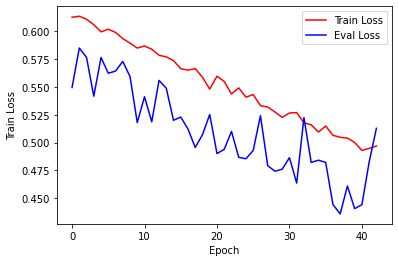

In [251]:
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")
plt.plot(train_losses, 'r')
plt.plot(test_losses, 'b')
plt.legend(['Train Loss', 'Eval Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

### Saving second model

In [252]:
# Save
PATH = "state_dict_model.pt"
torch.save(second_model.state_dict(), PATH)

In [253]:
# Testing params
VOCAB_SIZE = int(test_inputs.max()) + 1
TEST_VOCAB_SIZE = TRAIN_VOCAB_SIZE
lr = 0.01
BATCH_SIZE = 30

# Model params
EMBEDDING_DIM = 50
HIDDEN_DIM = 10
DROPOUT = 0.2

Best Threshold=0.502581, G-Mean=0.577
Amount of test data: 540


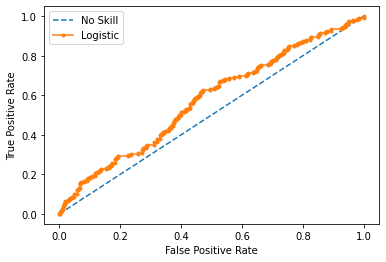

ROC Accuracy Score: 0.5749061438531672

Accuracy Score: 0.562962962962963

Confusion Matrix: 
[[183 163]
 [ 73 121]]

TP: 183	 FN: 163
FP: 73	 TN: 121

Precision: 0.71484375
Recall:0.5289017341040463
F1 Score: 0.5062761506276151


In [279]:
# Load Model
PATH = "state_dict_model.pt"
load_model = GRU(vocab_size=TEST_VOCAB_SIZE, hidden_dim=HIDDEN_DIM, embedding_dim=EMBEDDING_DIM, dropout=DROPOUT)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

# Test Model
from sklearn.metrics import f1_score
criterion = nn.BCELoss()
optimizer = optim.SGD(second_model.parameters(), lr=lr)

test_dataset = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_losses = []

with torch.no_grad():
    test_preds = []
    test_labels_list = []
    eval_losses = []

    for inputs, labels in test_loader:
        h = torch.Tensor(np.zeros((BATCH_SIZE, HIDDEN_DIM)))
        output, _ = second_model(inputs.to(torch.long), h)
        loss = criterion(output.squeeze(), labels.float())
        eval_losses.append(loss)
        preds = output.squeeze()
        if len(labels) > 1:
            test_preds += list(preds.numpy())
            test_labels_list += list(labels.numpy().astype(int))


roc_acc_score = roc_auc_score(test_labels_list, test_preds)

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# Index of largest G-means
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

# Print how many data is being tested
print(f"Amount of test data: {len(test_labels_list)}")


# Plot ROC Curve
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

    
print(f"ROC Accuracy Score: {roc_acc_score}")

# Normalize probability with threshold
test_preds_thresholded = np.where(test_preds > threshold, 1, 0)
for i in range(len(test_preds)-1140):
    print("Test Preds Prob: {}    \
    Test Preds Label: {}  \
    True Label: {}  \
    ".format(test_preds[i], test_preds_thresholded[i], test_labels_list[i]))

acc_score = accuracy_score(test_labels_list, test_preds_thresholded)
print(f"\nAccuracy Score: {acc_score}")


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels_list, test_preds_thresholded)
print(f"\nConfusion Matrix: \n{cm}")

tp = cm[0][0]
fp = cm[1][0]
fn = cm[0][1]
tn = cm[1][1]
print(f"\nTP: {tp}\t FN: {fn}\nFP: {fp}\t TN: {tn}\n")

# Precision
precision = tp/(tp+fp)
print(f"Precision: {precision}")

# Recall
recall = tp/(tp+fn)
print(f"Recall:{recall}")

# Calculate F1 Score
f1_score = f1_score(test_labels_list, test_preds_thresholded)
print(f"F1 Score: {f1_score}")